In [1]:
# The spelled-out intro to neural networks and backpropagation: building micrograd(https://youtu.be/VMj-3S1tku0?si=CnyW5BFfHFfUiDjF)


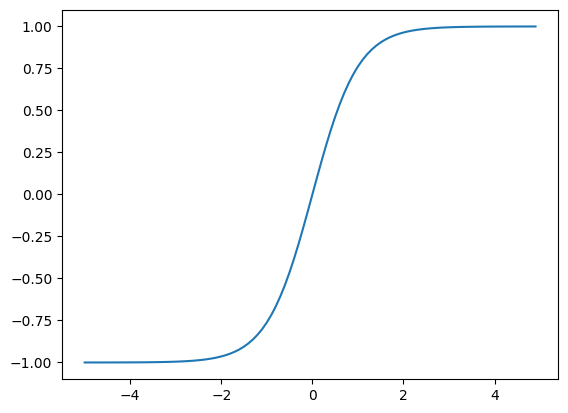

In [2]:
from matplotlib import pyplot as plt
import numpy as np

plt.plot(np.arange(-5,5,0.1), np.tanh(np.arange(-5,5,0.1)))


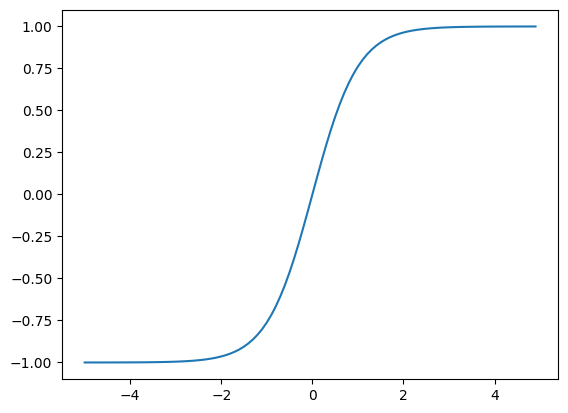

In [3]:
from matplotlib import pyplot as plt
import math

def tanh(x):
    exp2X = math.exp(2.0*x)
    t = (exp2X-1)/(exp2X+1)
    return t

def relu(x):
    if(x < 0.0):
        return 0;
    
    return x

input_range = [ j/10.0 for j in range(-50,50,1)]
tanh_range  = [tanh(j) for j in input_range]

plt.plot(input_range, tanh_range)

In [4]:
from graphviz import Digraph
import math

class Value:
    operator_precedence = {'+':1,'-':1,'*':2,'/':2, 'tanh':10, '**':9, 'exp':9, 'relu':10}
    
    def _draw_self(self, dot, draw_operators = False):
        uid = str(id(self))
        dot.node(uid, label = '{%s | data %.4f | grad %.4f}' % ((self.label[:25] + '..') if len(self.label) > 25 else self.label, self.data, self.grad), shape='record')
        if draw_operators and self._op:
                dot.node(name = uid + self._op, label = self._op)
                dot.edge(uid + self._op, uid)#op->value
                for n in self._prev:
                    dot.edge(str(id(n)), uid + self._op )#prev->operator
                    n._draw_self(dot, draw_operators)
        else:
            for n in self._prev:
                    dot.edge(str(id(n)), str(id(self)))#prev->self
                    n._draw_self(dot, draw_operators)

    def draw(self, draw_operators = False):
        dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
        self._draw_self(dot, draw_operators)
        return dot

    def label_from(self, other, op):
        self_part = ''
        other_part = ''
        if self._op and other._op and Value.operator_precedence[self._op] < Value.operator_precedence[op]:
            self_part = f'({self.label})'
        else:
            self_part = self.label

        if other._op and other._op and Value.operator_precedence[other._op] < Value.operator_precedence[op]:
            other_part = f'({other.label})'
        else:
            other_part = other.label
        return f'{self_part}{op}{other_part}'
                
    def __init__(self, data, _prev=(), _op='', label = 'unnamed'):
        self.data = data
        self._prev = set(_prev)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        self._forward = lambda: None

    def topologicaly_sorted_nodes(self, reverse):
        topo = []
        stack=[]
        stack.append(self)
        visited = {}
        while len(stack) != 0:
            v = stack.pop()
            if v in visited:
                index = visited[v]
                topo.pop(index)
                for ov in visited:
                    if visited[ov] > index:
                        visited[ov] = visited[ov] - 1
            visited[v] = len(topo)
            topo.append(v)
            for n in v._prev:
                stack.append(n)
        if reverse:
            return reversed(topo)
        return topo

    def topologicaly_sorted_nodes_recursive(self, reverse):
        visited = set()
        topo = []
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for n in v._prev:
                    build_topo(n)
                topo.append(v)
        build_topo(self)
        if reverse:
            return topo
        return reversed(topo)

    def backward(self):
        self.grad = 1.0
        for n in self.topologicaly_sorted_nodes(False):
            n._backward()

    def backward_recursive(self):
        self.grad = 1.0
        for n in self.topologicaly_sorted_nodes_recursive(False):
            n._backward()

    def zero_gradients(self):
        self.grad = 1.0
        for n in self.topologicaly_sorted_nodes(False):
            n.grad = 0.0

    def zero_gradients_recursive(self):
        self.grad = 1.0
        for n in self.topologicaly_sorted_nodes_recursive(False):
            n.grad = 0.0

    def forward(self, zero_gradients=False):
        for n in self.topologicaly_sorted_nodes(True):
            n._forward()
            if zero_gradients:
                for nc in n._prev:
                    nc.grad = 0.0

    def forward_recursive(self, zero_gradients=False):
        for n in self.topologicaly_sorted_nodes_recursive(True):
            n._forward()
            if zero_gradients:
                for nc in n._prev:
                    nc.grad = 0.0

    def __repr__(self):
        if self._op:
            return f'Value(data={self.data}, grad={self.grad}, label={self.label}, op={self._op})'
        else:
            return f'Value(data={self.data}, grad={self.grad}, label={self.label})'

    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other, label='%.4f' % other )
        out = Value(0.0, (self,other), '+', self.label_from(other,'+') )
        def _forward():
            out.data = self.data + other.data 
        out._forward = _forward
        def _backward():
            self.grad  += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other;

    def __mul__(self, other):
        assert id(other) != id(self)
        other = other if isinstance(other,Value) else Value(other, label='%.4f' % other )
        out = Value(0.0, (self,other), '*', self.label_from(other,'*'))
        def _forward():
            out.data = self.data * other.data 
        out._forward = _forward
        def _backward():
            self.grad  += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self,other):
        other = other if isinstance(other,Value) else Value(other, label='%.4f' % other )
        out = self * other**-1
        return out

    def __rtruediv__(self, other):
        other = other if isinstance(other,Value) else Value(other, label='%.4f' % other )
        return other/self

    def __pow__(self, other):
        assert isinstance(other,(int,float)), 'pow accepts only ints or floats'
        out = Value(0.0, (self, ), '**', f'{self.label}**{other}')
        def _forward():
            out.data = self.data**other
        out._forward = _forward
        def _backward():
            self.grad  += (other*self.data**(other - 1))*out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1.0

    def __sub__(self, other):
        return self + -other

    def __rsub__(self, other):
        return -self + other

    def tanh(self):
        out = Value(0.0, (self, ), 'tanh', f'tanh({self.label})')
        def _forward():
            x = self.data
            exp2X = math.exp(2.0*x)
            t = (exp2X-1)/(exp2X+1)
            out.data = t
        out._forward = _forward
        def _backward():
            x = self.data
            exp2X = math.exp(2.0*x)
            t = (exp2X-1)/(exp2X+1)
            self.grad  += (1 - t**2)*out.grad
        out._backward = _backward
        return out

    def tanh_slow(self):
        e = (2.0*self).exp()
        return (e-1)/(e+1)

    def relu(self):
        out = Value(0.0, (self,), 'relu', f'relu({self.label})')
        def _forward():
            out.data = 0.0 if self.data < 0.0 else self.data
        out._forward = _forward
        def _backward():
            self.grad  += (out.data >= 0) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(0.0, (self, ), 'exp', f'exp({self.label})')
        def _forward():
            out.data = math.exp(self.data)
        out._forward = _forward
        def _backward():
            self.grad  += out.data*out.grad
        out._backward = _backward
        return out

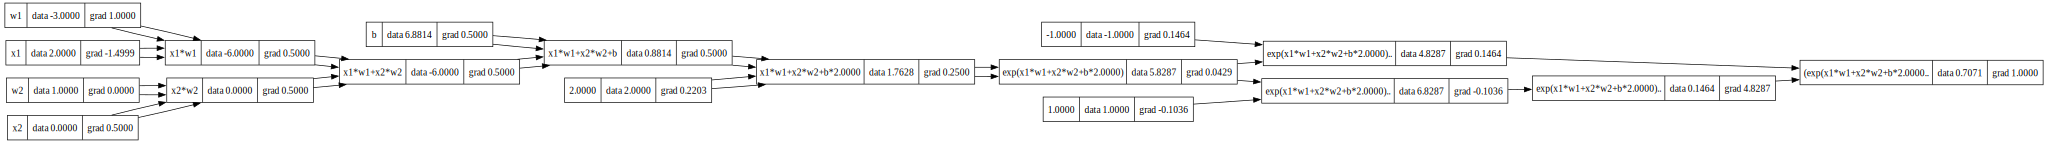

In [5]:
def test_0():
    x1 = Value(2.0, label = 'x1')
    x2 = Value(0.0, label = 'x2')
    w1 = Value(-3.0, label = 'w1')
    w2 = Value(1.0, label = 'w2')
    b = Value(6.8814, label = 'b')
    x1w1 = x1*w1
    x2w2 = x2*w2
    x1w1x2w2 = x1w1 + x2w2 
    pre_out = x1w1x2w2 + b
    out = (pre_out).tanh_slow()
    out.forward()
    out.backward()

    return out.draw()
test_0()

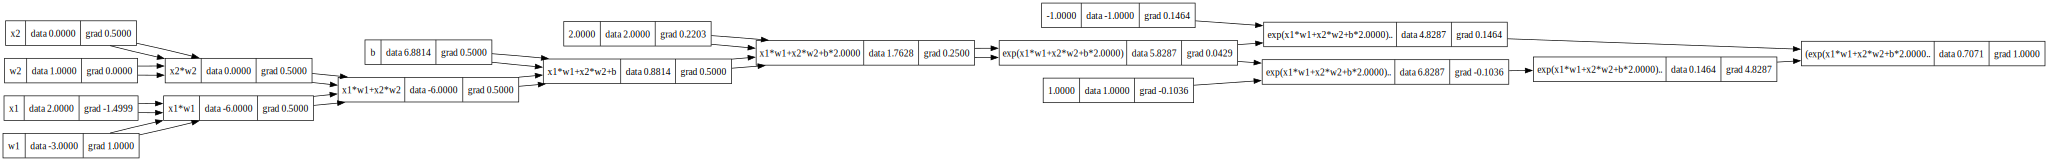

In [6]:
def test_1():
    x1 = Value(2.0, label = 'x1')
    x2 = Value(0.0, label = 'x2')
    w1 = Value(-3.0, label = 'w1')
    w2 = Value(1.0, label = 'w2')
    b = Value(6.8814, label = 'b')
    x1w1 = x1*w1
    x2w2 = x2*w2
    x1w1x2w2 = x1w1 + x2w2 
    pre_out = x1w1x2w2 + b
    out = (pre_out).tanh_slow()

    out.forward_recursive()
    out.backward_recursive()

    return out.draw()
test_1()

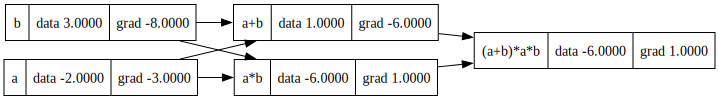

In [7]:
def test_2():
    a = Value(-2.0, label = 'a')
    b = Value(3.0, label = 'b')
    f = (a + b) * (a * b)

    f.forward()
    f.backward()

    return f.draw()
test_2()

In [8]:
import torch

def test_vs_pytorch():
    def ours():
        w1 = Value(-3.0, label = 'w1')
        w2 = Value(1.0, label = 'w2')
        b = Value(6.88138, label = 'b')
        out = (w1*2.0 + w2*0.0 + b).tanh()
        out.forward()
        out.backward()
        print(f'data = {w1.data}, grad = {w1.grad}')
        print(f'data = {w2.data}, grad = {w2.grad}')
        print(f'data = {b.data}, grad = {b.grad}')
        print(f'data = {out.data}, grad = {out.grad}')
    def pytorch():
        w1 = torch.tensor([-3.0], dtype=torch.float64, requires_grad=True)
        w2 = torch.tensor([1.0], dtype=torch.float64, requires_grad=True)
        b = torch.tensor([6.88138], dtype=torch.float64, requires_grad=True)
        out = torch.tanh(2.0*w1 + 0.0*w2 + b);
        out.backward()
        print(f'data = {w1.data.item()}, grad = {w1.grad.item()}')
        print(f'data = {w2.data.item()}, grad = {w2.grad.item()}')
        print(f'data = {b.data.item()}, grad = {b.grad.item()}')
        print(f'data = {out.data.item()}, grad = {1.0}')
    ours()
    print('-----------')
    pytorch()
test_vs_pytorch()

data = -3.0, grad = 0.9999909306966255
data = 1.0, grad = 0.0
data = 6.88138, grad = 0.49999546534831274
data = 0.7071099876622358, grad = 1.0
-----------
data = -3.0, grad = 0.9999909306966255
data = 1.0, grad = 0.0
data = 6.88138, grad = 0.49999546534831274
data = 0.7071099876622358, grad = 1.0


In [9]:
import random

class Neuron:
    def __init__(self, number_of_inputs, index):
        self.w = [Value(random.uniform(-1.0,1.0), label=f'w{index}:{i}') for i in range(number_of_inputs)]
        self.b = Value(random.uniform(-1.0,1.0), label=f'b{index}')

    def __call__(self, inputs):
        act = sum((wi*xi for wi,xi in zip(self.w, inputs)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, number_of_inputs, number_of_outputs, index):
        self.neurons = [Neuron(number_of_inputs, index + i) for i in range(number_of_outputs)]

    def __call__(self, inputs):
        outs = [n(inputs) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:
    def __init__(self, number_of_inputs, number_of_outputs):
        size = [number_of_inputs] + number_of_outputs
        self.layers = [Layer(size[i], size[i+1], i) for i in range(len(number_of_outputs))]

    def __call__(self, inputs):
        x = inputs
        for l in self.layers:
            x = l(x)
        return x

    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

    def assemble_training_set(self, xs, ys):
        ypred = [n(x) for x in xs]
        loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])
        return ypred,loss

    def train(self, loss, train_rate, iterations):
        for _ in range(iterations):

            #forward
            loss.forward(zero_gradients = True)

            #backword
            loss.backward()

            #update params
            for p in self.parameters():
                p.data += -train_rate * p.grad

            #print(loss.data)

In [12]:
n = MLP(3, [4, 4, 1])

xs = [
    [2.0,  3.0, -1.0],
    [3.0, -1.0,  0.5],
    [0.5,  1.0,  1.0],
    [1.0,  1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred, loss = n.assemble_training_set(xs,ys)

for i in range(5):
    n.train(loss, 0.2/(i + 1), 50)
    print(f'{loss.data} -> {[y.data for y in ypred]}')

0.00017378518296172157 -> [0.9955568277420054, -0.9970760935239301, -0.9901892979379907, 0.9929825717519029]
0.00016660228850179457 -> [0.995625422887846, -0.9971296793016731, -0.9904468533550329, 0.9930743944770062]
0.0001622071371002246 -> [0.995669100314095, -0.9971632323350093, -0.9906058340549692, 0.9931332074137238]
0.00015908362485096613 -> [0.995700959295378, -0.9971874429397789, -0.9907194755796682, 0.9931762720498546]
0.00015668151447736402 -> [0.9957259356448056, -0.9972062735471876, -0.9908072507840194, 0.9932101294030029]
